<a href="https://colab.research.google.com/github/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<a href="https://github.com/WinetraubLab/coregister-xy/blob/main/reconstruct_3d.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
Use this notebook to stack together multiple 2D H&E images to 3D stack

In [ ]:
# @title Inputs

# Define output volume
x_range_mm = [-1, 1]
y_range_mm = [-1, 1]
pixel_size_mm = 1e-3 # 1 micron is 1e-3

# Define input planes
plane_inputs = []

# Upload image files and replace the below with your plane_inputs:
plane_inputs.append({
"uv_pix": [[860.1, 1201.4], [597.2, 1953.6], [1653.2, 1431.3]],
"xyz_mm": [[0, 0, 0.01], [1, 0, 0.01], [0, 1, 0.01]],
"image_file_path": "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-09-04 Multiple Barcode Alignment/s1s1.tif"
})
plane_inputs.append({
"uv_pix": [[1073.6, 850.1], [778.1, 1483.9], [1756.6, 1111.4]],
"xyz_mm": [[0.0, 0.0, 0.014], [1.0, 0.0, 0.012], [0.0, 1.0, 0.014]],
"image_file_path": "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2024-09-04 Multiple Barcode Alignment/s1s2.tif"
})

In [ ]:
# @title Environment Setup

from google.colab import drive
drive.mount('/content/drive')

!git clone https://github.com/WinetraubLab/coregister-xy.git
%cd coregister-xy

from plane.fit_plane import FitPlane
import matplotlib.pyplot as plt
import os
from google.colab import files
import math
import pandas as pd
import numpy as np
import cv2
from PIL import Image
import tifffile

%cd ..

Mounted at /content/drive
Cloning into 'coregister-xy'...
remote: Enumerating objects: 837, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 837 (delta 113), reused 75 (delta 63), pack-reused 668 (from 2)
Receiving objects: 100% (837/837), 1.27 MiB | 11.35 MiB/s, done.
Resolving deltas: 100% (521/521), done.
/content/coregister-xy
/content


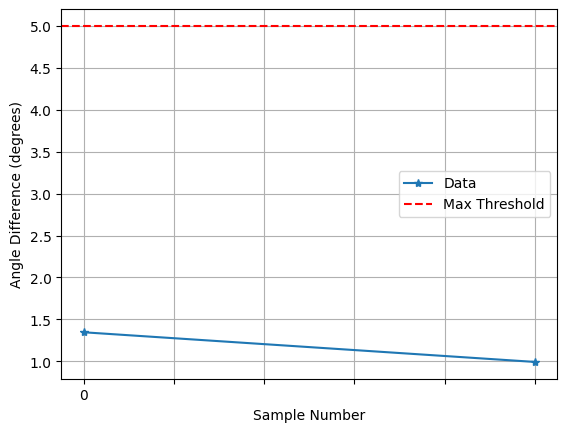

In [ ]:
# @title Fit planes

# Fit individual planes
fps = []
for plane_input in plane_inputs:
  fp = FitPlane.from_template_centers(plane_input['uv_pix'],plane_input['xyz_mm'])
  fps.append(fp)

# Find average normal to all
group_normal = np.array([0,0,0])
for fp in fps:
  group_normal = group_normal + fp.normal_direction()
group_normal = group_normal / np.linalg.norm(group_normal)

# Plot differences from the normal
normal_diff_angle_deg = []
for fp in fps:
  normal_diff_angle_deg.append(np.arccos(np.dot(fp.normal_direction()/np.linalg.norm(fp.normal_direction()),group_normal))*180/np.pi)plt.plot(normal_diff_angle_deg, '-*', label='Data')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '%d' % val if val % 1 == 0 else ''))
plt.xlabel('Sample Number')
plt.ylabel('Angle Difference (degrees)')
plt.grid(True)
plt.axhline(y=5, color='r', linestyle='--', label='Max Threshold')
plt.legend()
plt.show()

# Fit individual planes while considering the overall normal
fps2 = []
for plane_input in plane_inputs:
  fp = FitPlane.from_template_centers(
      plane_input['uv_pix'],plane_input['xyz_mm'],
      forced_plane_normal = group_normal)
  fps2.append(fp)

In [ ]:
# @title Construct the 3D volume

# Obtain planes images
img_crops = []
image_distances_mm = []
for fp, plane_input in zip(fps2,plane_inputs):
  # Load image and project to the common space
  img = cv2.imread(plane_input["image_file_path"], cv2.IMREAD_COLOR)
  img_crop  = fp.image_to_physical(img, x_range_mm, y_range_mm, pixel_size_mm)
  img_crops.append(img_crop)

  # Store the distance
  image_distances_mm.append(fp.distance_from_origin_mm())
image_distances_mm = np.array(image_distances_mm)

# Build Tiff
empty_crop = np.zeros_like(img_crops[0])
z_min = np.min(image_distances_mm)
z_max = np.max(image_distances_mm)
tiff_stack = []
for z in np.arange(z_min, z_max, pixel_size_mm):
  # Find the closest fp
  diffs = np.abs(image_distances_mm - z)
  min_diff = np.min(diffs)
  min_index = np.argmin(diffs)

  if min_diff < 5e-3/2: # Less than thickness of a slide, use this image
    t = img_crops[min_index]
  else:
    t = empty_crop

  tiff_stack.append(Image.fromarray(cv2.cvtColor(t, cv2.COLOR_BGR2RGB)))

tiff_stack = np.array(tiff_stack).astype(np.uint8)

tifffile.imwrite(
     'output_multipage.tiff',
     tiff_stack,
     bigtiff=True,
     resolution=(10 / pixel_size_mm, 10 / pixel_size_mm),
     resolutionunit='centimeter',
     compression='deflate' # Lossless compression
 )

In [ ]:
# @title Save file to computer
from google.colab import files

# Get file size in bytes
file_size = os.path.getsize('output_multipage.tiff')
print(f"File size: {file_size / (1024 * 1024):.2f} MB/{file_size / (1024 * 1024 * 1024):.2f} GB")

with tifffile.TiffFile('output_multipage.tiff') as tif:
    # Count the number of pages
    num_pages = len(tif.pages)
    print(f"The TIFF file contains {num_pages} pages.")

print('Open the File in ImageJ!')
files.download("output_multipage.tiff")

File size: 14.09 MB/0.01 GB
The TIFF file contains 4 pages.
Open the File in ImageJ!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>